In [3]:
import numpy as np
import pandas as pd
import keras
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Conv2D, Flatten, Dense, Activation, MaxPooling2D, Dropout, Input, BatchNormalization
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('analog_clocks/label.csv')

In [5]:
data.head()

len(data)

50000

In [6]:
def preprocess(im):
    
    im = im/255
    im -= .5
    return im

In [7]:
channel = 1
im_size = 100

In [8]:
def load_image_batch(ids, batch_size=32):
    
    path = 'analog_clocks/images/'
    image_batch = np.zeros((batch_size, im_size, im_size, channel))
    
    label_hour = np.zeros((batch_size, 1))
    label_min = np.zeros((batch_size, 1))
    batch_ids = np.random.choice(ids, batch_size)
    
    ind = 0
    for i in range(len(batch_ids)):
        
        if channel == 1:
            im = Image.open(path + str(batch_ids[i]) + '.jpg').convert('L')
        else:
            im = Image.open(path + str(batch_ids[i]) + '.jpg')
        im = im.resize((im_size,im_size), Image.ANTIALIAS)
        im = np.array(im)
        image_batch[ind] = preprocess(im).reshape((im_size, im_size, channel))
        label_hour[ind] = (data['hour'][data.index==batch_ids[i]])
        label_min[ind] = (data['minute'][data.index==batch_ids[i]])/60
        ind += 1
            
    return (np.array(image_batch), np.array(label_hour), np.array(label_min))

In [113]:
inp = Input(shape=(im_size,im_size, channel))

x = Conv2D(50, kernel_size=5, strides=2, activation='relu')(inp)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
x = BatchNormalization()(x)

x = Conv2D(100, kernel_size=3, strides=1, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(150, kernel_size=3, strides=1, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(200, kernel_size=3, strides=1, activation='relu')(x)
x = Dropout(.4)(x)

x = Flatten()(x)

hour = Dense(144, activation='relu')(x)
hour = Dense(144, activation='relu')(hour)
hour = Dense(12, activation='softmax', name='hour')(hour)

minute = Dense(100, activation='relu')(x)
minute = Dense(200, activation='relu')(minute)
minute = Dense(1, activation='linear', name='minute')(minute)

model = Model(inputs=inp, outputs=[hour, minute])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
conv2d_148 (Conv2D)             (None, 48, 48, 50)   1300        input_37[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_84 (MaxPooling2D) (None, 24, 24, 50)   0           conv2d_148[0][0]                 
__________________________________________________________________________________________________
batch_normalization_111 (BatchN (None, 24, 24, 50)   200         max_pooling2d_84[0][0]           
__________________________________________________________________________________________________
conv2d_149

In [15]:
train_ids = np.arange(40000)
test_ids = np.arange(10000) + 40000

x, y1, y2 = load_image_batch(train_ids, 40000)

x1, z1, z2 = load_image_batch(test_ids, 500)

In [122]:
adam = keras.optimizers.adam(lr=.00001)
model.compile(loss=['sparse_categorical_crossentropy', 'mse'], optimizer=adam, metrics=['accuracy', 'mae'])

In [127]:
model.fit(x, [y1, y2], epochs=1, batch_size=256, validation_data=(x1, [z1, z2]))

Train on 40000 samples, validate on 100 samples
Epoch 1/1
40000/40000 [==============================] - 15s 376us/step - loss: 0.0112 - hour_loss: 0.0025 - minute_loss: 0.0086 - hour_acc: 0.9994 - hour_mean_absolute_error: 5.4811 - minute_acc: 0.0160 - minute_mean_absolute_error: 0.0683 - val_loss: 0.0577 - val_hour_loss: 0.0480 - val_minute_loss: 0.0097 - val_hour_acc: 0.9900 - val_hour_mean_absolute_error: 5.1767 - val_minute_acc: 0.0300 - val_minute_mean_absolute_error: 0.0691


## Testing

In [12]:
model = keras.models.load_model('model/time_det.model')

In [82]:
def predict(ind):
        
    path = 'analog_clocks/images/'
            
    im = Image.open(path + str(ind) + '.jpg')
    plt.imshow(im)
    print('input image:')
    plt.show()
    im = im.convert('L')
    im = im.resize((im_size,im_size), Image.ANTIALIAS)
    im = np.array(im)
    im = preprocess(im).reshape((1, im_size, im_size, channel))

    time = model.predict(im)
    
    hour = np.argmax(time[0])
    minute = int(time[1][0][0]*60)
    print('Detected Time:', str(hour)+':'+str(minute))

input image:


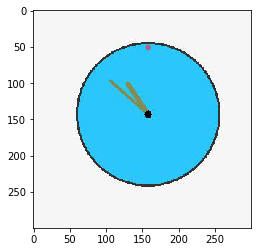

Detected Time: 10:53


In [83]:
predict(test_ids[5])